In [ ]:
import subprocess 
from deepBreaks.utils import load_obj
from deepBreaks.preprocessing import read_data
import pandas as pd
import shap
import os
import sys
import numpy as np
import tempfile

In [3]:
wrk_dir = '.' # Assume current directory
# This needs to be a real path to one of your trained models
model = "e:/safra/Documents/GitHub/optics/models/reg_models/vpod_1.2\one_hot/wt_mnm_gbr.pkl"

loaded_mod = load_obj(model)

# This should be the path to the data the model was trained on
alignment_data = "e:/safra/Documents/GitHub/optics/data/fasta/vpod_1.2/wt_mnm_aligned_VPOD_1.2_het.fasta"
metaDataFileName = 'e:/safra/Documents/GitHub/optics/data/fasta/vpod_1.2/wt_mnm_meta.csv'
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
mt = 'Lambda_Max'
seq_type = 'aa'
y = meta_data.loc[:, mt].values

In [4]:
# Two example sequences to compare
sequence1 = ">AncVert\nMDNDSTEGPDVNNTTGDPFEGPQYPHLAPRWTFLLMAVLMGFVVVASSPVNGLVLVVTLKYKKLRQPLNYILVNLAVADLLVTFFGSTISFFNNVNGYFILGHSVCKLEGFMVSLSGIVGLWSLAVLAFERYIVICKPMGNFRFQGKHAVIGVAFTWVWSLVWTTPPLFGWSRYVPEGLRTSCGPDWYTGEYNNQSYVMMLFVTCFVMPLSIIIFSYGQLLVTLRAVAAQQKESETTQKAEREVTRMVIVMVMAFLICWLPYATFALFVATNRGIAFDPRLASMPAYFSKSATVYNPIIYVFMNKQFRNCMLQMLCCGKNPFGDDDESDASGSSTASRTEVSSVSSGGSSKVPA"
sequence2 = ">AncArthro\nPMWHYLLGLIYIILGIVSVVGNGLVIYIFSKTKSLRTPSNMLVVNLAFSDFMMMLTQFPMFIYNSFSNETWVFGPFACEIYGFCGALFGVASIVTMAVIAFDRYNVIVKGFSGKRMTHGRAVVLILFVWVYALGWALPPFFGWNRYVPEGFLTSCSFDYLTEDWNSRSFIFCLFVFAYCLPLLIIIYCYFFIVRAVCEHEKQLREQAKKMNVASLRSNEDQQKQSAEIRIAKVALTNVSLWVVAWTPYAVVALMGVFGDQELITPLVSQLPALFAKTAAVYNPIVYAISHPKYRQALQKKLPWLCC"

In [7]:
with tempfile.NamedTemporaryFile(mode="w", dir=f"{wrk_dir}/tmp", suffix=".fasta", delete=False) as temp_seq_file:
    temp_seq = temp_seq_file.name  # Get the unique filename
    #print(temp_seq)
    if '>' in sequence1:
        temp_seq_file.write(sequence1)
    else:
        sequence = ">placeholder_name\n" + sequence1
        temp_seq_file.write(sequence1)
with tempfile.NamedTemporaryFile(mode="w", dir=f"{wrk_dir}/tmp", suffix=".fasta", delete=False) as temp_ali_file:
    new_ali = temp_ali_file.name  
    
mafft_exe = f'e:\\safra\\Documents\\GitHub\\optics\\optics_scripts/mafft/mafft-win/mafft.bat'
cmd = [mafft_exe, '--add', temp_seq, '--keeplength', alignment_data]

with open(new_ali, 'w') as f:
    subprocess.run(cmd, stdout=f, stderr=subprocess.PIPE)
    
full_alignment = read_data(new_ali, seq_type = seq_type, is_main=True, gap_threshold=0.5)
ref_copy = read_data(alignment_data, seq_type = seq_type, is_main=True, gap_threshold=0.5)
last_seq = int(ref_copy.shape[0])

new_seq_test = full_alignment.iloc[last_seq:].copy()

prediction1 = loaded_mod.predict(new_seq_test)

processed_seq1 = loaded_mod[0].transform(new_seq_test)


In [8]:
with tempfile.NamedTemporaryFile(mode="w", dir=f"{wrk_dir}/tmp", suffix=".fasta", delete=False) as temp_seq_file:
    temp_seq = temp_seq_file.name  # Get the unique filename
    #print(temp_seq)
    if '>' in sequence2:
        temp_seq_file.write(sequence2)
    else:
        sequence = ">placeholder_name\n" + sequence2
        temp_seq_file.write(sequence2)
with tempfile.NamedTemporaryFile(mode="w", dir=f"{wrk_dir}/tmp", suffix=".fasta", delete=False) as temp_ali_file:
    new_ali = temp_ali_file.name  

mafft_exe = f'e:\\safra\\Documents\\GitHub\\optics/optics_scripts/mafft/mafft-win/mafft.bat'
cmd = [mafft_exe, '--add', temp_seq, '--keeplength', alignment_data]

with open(new_ali, 'w') as f:
    subprocess.run(cmd, stdout=f, stderr=subprocess.PIPE)
    
full_alignment = read_data(new_ali, seq_type = seq_type, is_main=True, gap_threshold=0.5)
ref_copy = read_data(alignment_data, seq_type = seq_type, is_main=True, gap_threshold=0.5)
last_seq = int(ref_copy.shape[0])

new_seq_test = full_alignment.iloc[last_seq:].copy()

prediction2 = loaded_mod.predict(new_seq_test)

processed_seq2 = loaded_mod[0].transform(new_seq_test)

In [9]:
encoded_seqs = loaded_mod[0].transform(ref_copy)
encoded_seqs.head()


,p1_M,p1_P,p2_GAP,p2_KGDEMQYIPLHFV,p2_R,p2_S,p2_T,p3_G,p3_S,p4_G,...,p349_GAP,p349_S,p349_TVRDEQIFHNPKYLCM,p350_GAP,p350_P,p350_S,p350_TEKQNRGDLVI,p351_GAP,p351_NKTHPQDGLMRVC,p351_S
Bovine,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
S1,True,False,False,False,False,False,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
S2,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
S3,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
S4,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [10]:
# The base value is the average prediction over the entire training set
explainer = shap.TreeExplainer(loaded_mod[-1], encoded_seqs)
base_value = explainer.expected_value
print(f"SHAP Base Value (Average Predicted λmax): {float(base_value):.2f} nm")


SHAP Base Value (Average Predicted λmax): 479.20 nm


In [11]:
seq1_shap = explainer.shap_values(processed_seq1)
seq2_shap = explainer.shap_values(processed_seq2)

In [12]:
shap_diff = seq1_shap[0] - seq2_shap[0]

In [13]:
# Identify which features are different *after* transformation
changed_features_mask = (processed_seq1.values[0] != processed_seq2.values[0])

In [15]:
comparison_df = pd.DataFrame({
    'feature': np.array(processed_seq1.columns)[changed_features_mask],
    'seq1_states': processed_seq1.values[0][changed_features_mask],
    'seq2_states': processed_seq2.values[0][changed_features_mask],
    'shap_difference': shap_diff[changed_features_mask]
})
comparison_df['seq1_states']=comparison_df['seq1_states'].replace(True, 1)
comparison_df['seq1_states']=comparison_df['seq1_states'].replace(0.0, 0)
comparison_df['seq2_states']=comparison_df['seq2_states'].replace(True, 1)
comparison_df['seq2_states']=comparison_df['seq2_states'].replace(0.0, 0)

comparison_df['abs_shap_diff'] = comparison_df['shap_difference'].abs()
comparison_df.head()


C:\Users\safra\AppData\Local\Temp\ipykernel_23256\1910653705.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison_df['seq1_states']=comparison_df['seq1_states'].replace(True, 1)
C:\Users\safra\AppData\Local\Temp\ipykernel_23256\1910653705.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison_df['seq2_states']=comparison_df['seq2_states'].replace(True, 1)


,feature,seq1_states,seq2_states,shap_difference,abs_shap_diff
0,p2_GAP,0.0,1.0,-0.016314,0.016314
1,p4_GAP,0.0,1.0,0.839520,0.839520
2,p4_T,1.0,0.0,-0.036198,0.036198
3,p5_GAP,0.0,1.0,-0.054626,0.054626
4,p23_E,1.0,0.0,-0.021834,0.021834


In [16]:
comparison_df_copy = comparison_df.copy()
comparison_df_copy=comparison_df_copy.reset_index(drop=True).set_index('feature')
comparison_df_copy

,seq1_states,seq2_states,shap_difference,abs_shap_diff
feature,,,,
p2_GAP,0.0,1.0,-0.016314,0.016314
p4_GAP,0.0,1.0,0.839520,0.839520
p4_T,1.0,0.0,-0.036198,0.036198
p5_GAP,0.0,1.0,-0.054626,0.054626
p23_E,1.0,0.0,-0.021834,0.021834
...,...,...,...,...
p349_TVRDEQIFHNPKYLCM,1.0,0.0,0.137248,0.137248
p350_GAP,0.0,1.0,0.172008,0.172008
p350_S,1.0,0.0,-0.358405,0.358405


In [17]:
print(f"\nSum of SHAP differences: {comparison_df['shap_difference'].sum():.2f}")
print(f"Actual prediction difference: {prediction1[0] - prediction2[0]:.2f}")


Sum of SHAP differences: -7.43
Actual prediction difference: -12.16


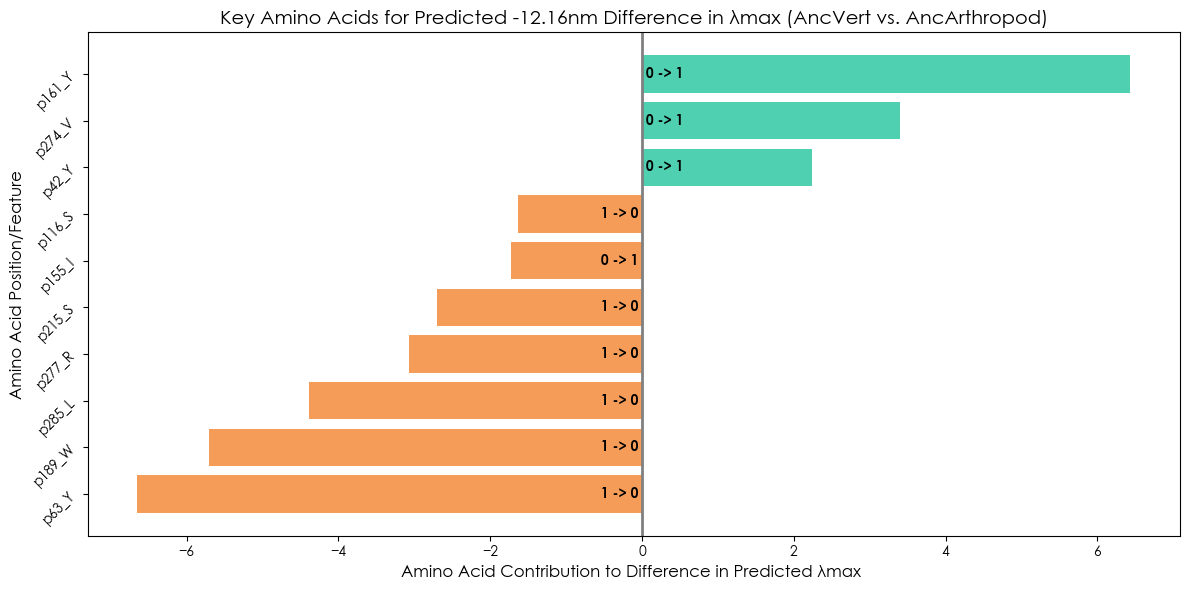

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Century Gothic'

comparison_df = comparison_df.sort_values(by='abs_shap_diff', ascending=False).head(10)
comparison_df = comparison_df.sort_values(by='shap_difference')

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#f5954bed" if x < 0 else "#30c8a4d9" for x in comparison_df['shap_difference']]
bars = ax.barh(comparison_df['feature'], comparison_df['shap_difference'], color=colors)

for i, bar in enumerate(bars):
    aa_a = comparison_df['seq1_states'].iloc[i]
    aa_b = comparison_df['seq2_states'].iloc[i]
    ax.text(0, bar.get_y() + bar.get_height()/2, f' {aa_a:.0f} -> {aa_b:.0f} ',
            va='center', ha='right' if bar.get_width() < 0 else 'left',
            color='black', fontweight='bold', fontsize=10)

ax.axvline(0, color='grey', linewidth=2)
ax.set_xlabel(f'Amino Acid Contribution to Difference in Predicted λmax ', fontsize=12)
ax.set_ylabel('Amino Acid Position/Feature', fontsize=12)
plt.yticks(rotation=45)
ax.set_title(f'Key Amino Acids for Predicted {prediction1[0] - prediction2[0]:.2f}nm Difference in λmax (AncVert vs. AncArthropod)', fontsize=14)
plt.tight_layout()
#plt.savefig(output_path, dpi=150)
plt.show()
plt.close()


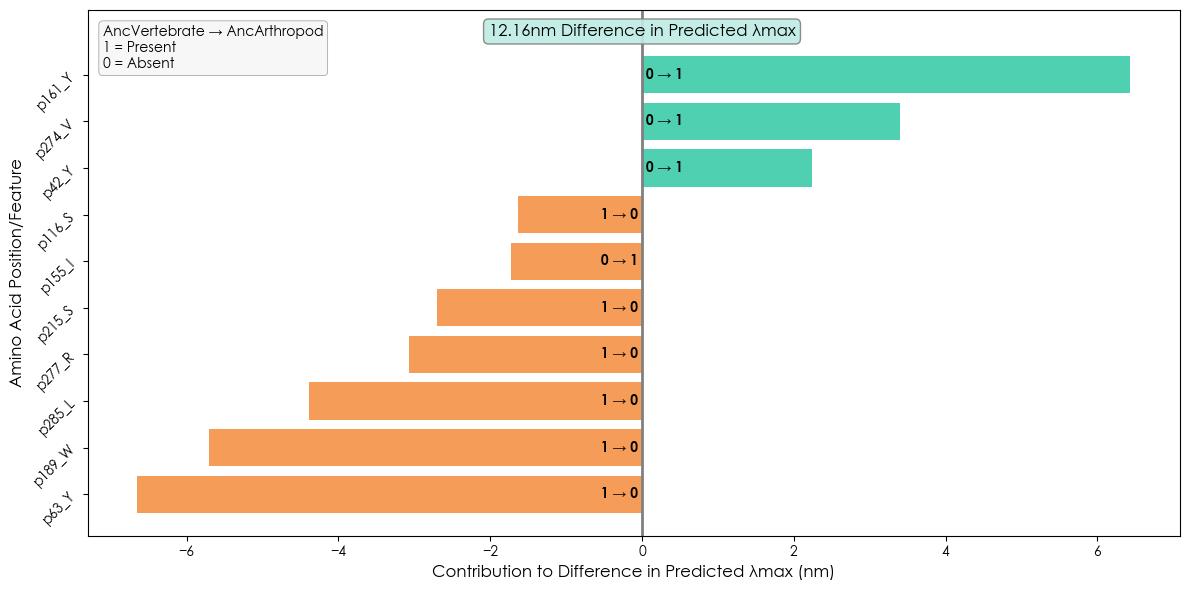

In [67]:

plt.rcParams['font.family'] = 'Century Gothic'

comparison_df = comparison_df.sort_values(by='abs_shap_diff', ascending=False).head(10)
comparison_df = comparison_df.sort_values(by='shap_difference')

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#f5954bed" if x < 0 else "#30c8a4d9" for x in comparison_df['shap_difference']]
bars = ax.barh(comparison_df['feature'], comparison_df['shap_difference'], color=colors)

for i, bar in enumerate(bars):
    aa_a = comparison_df['seq1_states'].iloc[i]
    aa_b = comparison_df['seq2_states'].iloc[i]
    ax.text(0, bar.get_y() + bar.get_height()/2, f' {aa_a:.0f} → {aa_b:.0f} ',
            va='center', ha='right' if bar.get_width() < 0 else 'left',
            color='black', fontweight='bold', fontsize=10)

ax.axvline(0, color='grey', linewidth=2)
ax.set_xlabel(f'Contribution to Difference in Predicted λmax (nm)', fontsize=12)
ax.set_ylabel('Amino Acid Position/Feature', fontsize=12)
plt.yticks(rotation=45)
#ax.set_title(f'Key Amino Acids for Predicted {prediction1[0] - prediction2[0]:.2f}nm Difference in λmax (AncVert vs. AncArthropod)', fontsize=14)

# 1. Get the current y-axis limits before changing them.
ymin, ymax = ax.get_ylim()

# 2. Increase the top y-axis limit to make space for the text.
#    Adding 1.0 gives enough room for one line of text above the top bar.
ax.set_ylim(ymin, ymax + 0.5)

# 3. Add the base value annotation at the top center (x=0).
#    I've added a background box to make it stand out.
ax.text(0, ymax + 0.2, # x=0 for center, y is just above the original top bar
        f'{abs(prediction1[0] - prediction2[0]):.2f}nm Difference in Predicted λmax',
        ha='center', # Horizontal alignment
        va='top', # Vertical alignment
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc="#bdece3ac", ec='grey', lw=1, alpha=0.9))

# Add the new legend for state change notation
legend_text = f"AncVertebrate → AncArthropod\n1 = Present\n0 = Absent"
fig.text(0.09, 0.95, legend_text, ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='whitesmoke', ec='grey', lw=0.5, alpha=0.8))

#plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust layout to prevent legend overlap
plt.tight_layout()
#plt.savefig(output_path, dpi=150)
plt.show()
plt.close()

In [75]:
shap_values = explainer(encoded_seqs)

In [70]:
shap.plots.initjs()


In [92]:
shap.plots.force(shap_values[79])


In [91]:
shap.plots.force(shap_values[500])


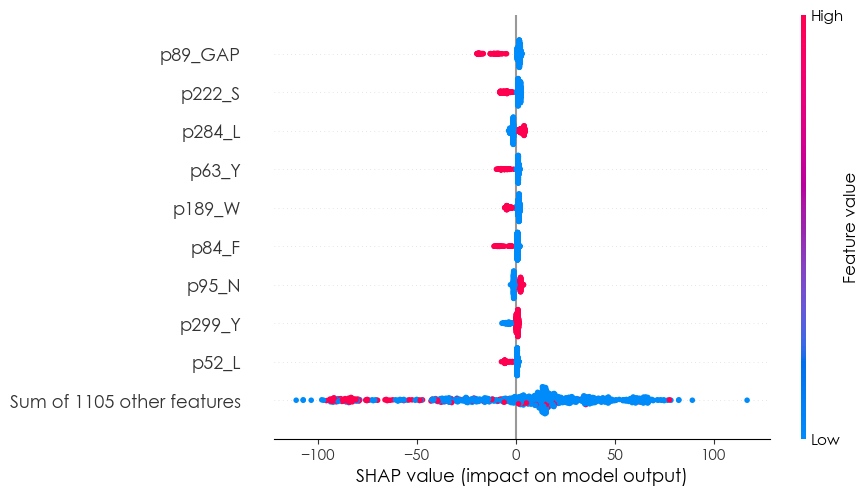

In [85]:
shap.plots.beeswarm(shap_values)


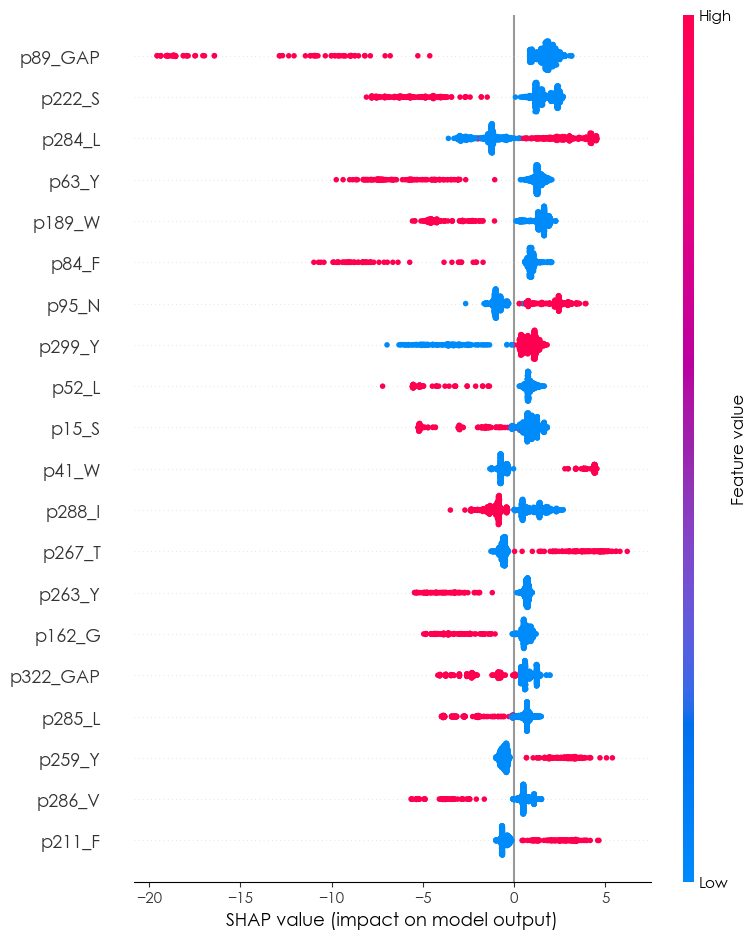

In [87]:
shap.summary_plot(shap_values)

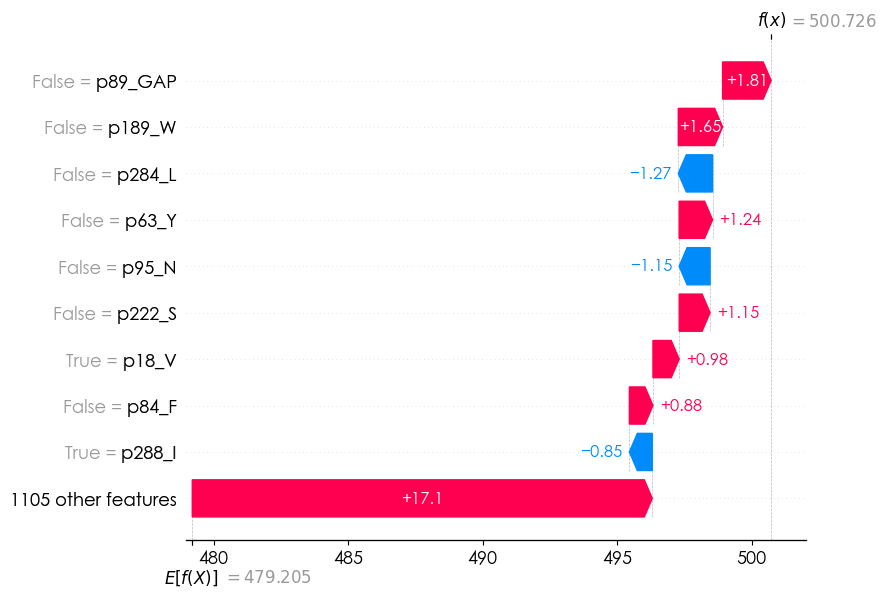

In [98]:
shap.plots.waterfall(shap_values[0])